# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

*This data represents 17 marketing campaigns.*

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.compose import make_column_transformer,ColumnTransformer
import time

In [42]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [44]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [45]:
#Null check in the Dataset
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [46]:
# Check for Duplicate Data
df.duplicated().sum()

np.int64(12)

In [47]:
# Dropping Duplicates - 12 Rows
df.drop_duplicates(inplace=True)

In [48]:
# Check for Imbalance in the Target Column
(df['y'].value_counts(normalize=True)*100).round(2)

,proportion
y,
no,88.73
yes,11.27


In [49]:
# Translate Y values to Numerical Representation for usage in Models.
df['y']=df['y'].map({'yes':1,'no':0})

In [50]:
# Summary of Stats for Numerical Features.
target = 'y'
num_cols = df.select_dtypes(include=np.number).columns.tolist()
attributes = [col for col in num_cols if col != target]
attributes_mean = df.groupby(target)[attributes].mean().T
attributes_mean['abs_diff'] = abs(attributes_mean.iloc[:,0] - attributes_mean.iloc[:,1])
attributes_mean.sort_values(by='abs_diff',ascending=False,inplace=True)
print(attributes_mean)

y                         0            1    abs_diff
duration         220.868079   553.256090  332.388011
pdays            984.109396   791.990946  192.118450
nr.employed     5176.165690  5095.120069   81.045621
euribor3m          3.811482     2.123362    1.688120
emp.var.rate       0.248885    -1.233089    1.481974
age               39.910994    40.912266    1.001271
cons.conf.idx    -40.593232   -39.791119    0.802113
campaign           2.633385     2.051951    0.581434
previous           0.132414     0.492779    0.360365
cons.price.idx    93.603798    93.354577    0.249221


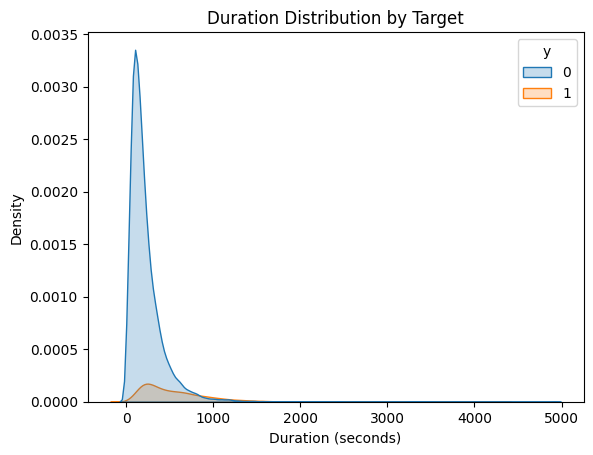

In [51]:
# Dense Plot on Duration
sns.kdeplot(data=df, x='duration', hue='y', fill=True)
plt.title('Duration Distribution by Target')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.show()

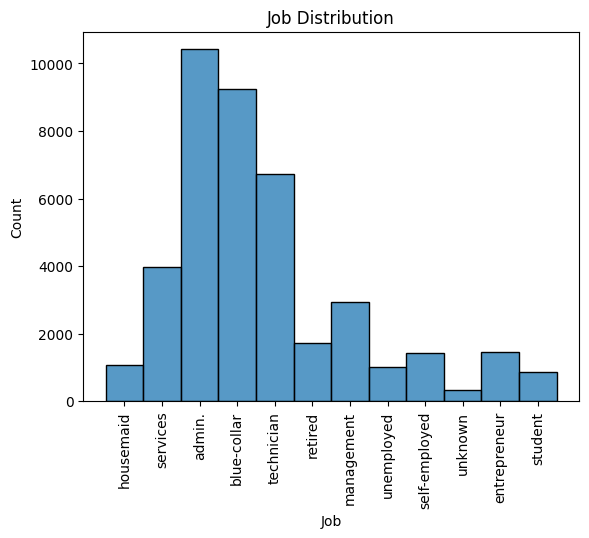

In [52]:
#Hist plot for job
sns.histplot(data=df,x='job')
plt.xticks(rotation=90);
plt.title('Job Distribution')
plt.xlabel('Job')
plt.show();

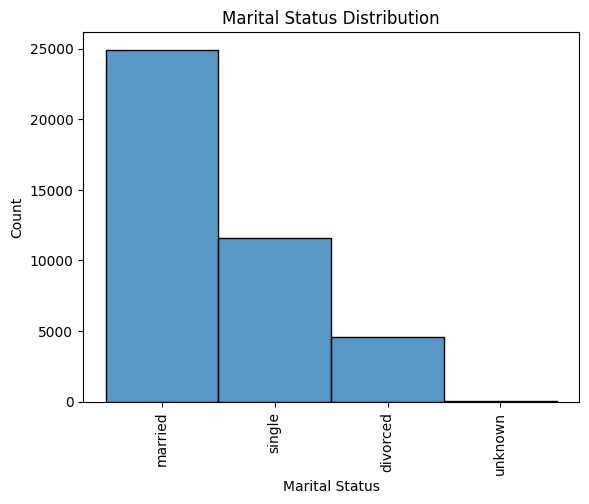

In [53]:
#Hist Plot on Marital Status
sns.histplot(data=df,x='marital')
plt.xticks(rotation=90);
plt.title('Marital Status Distribution')
plt.xlabel('Marital Status')
plt.show();

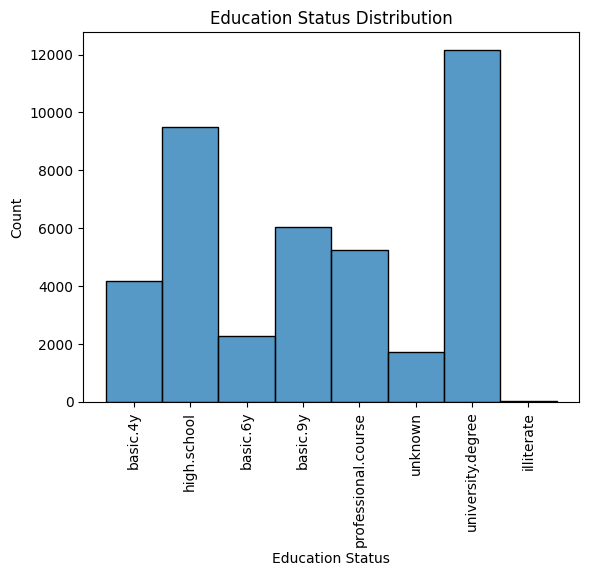

In [54]:
# Hist plot on Education
sns.histplot(data=df,x='education')
plt.xticks(rotation=90);
plt.title('Education Status Distribution')
plt.xlabel('Education Status')
plt.show();

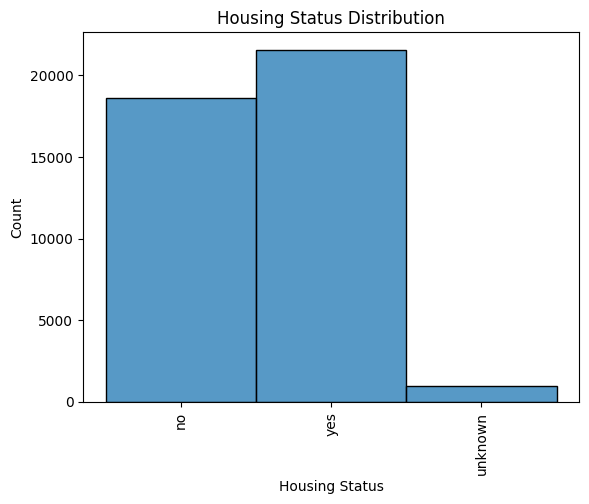

In [55]:
# Hist plot on Housing
sns.histplot(data=df,x='housing')
plt.xticks(rotation=90);
plt.title('Housing Status Distribution')
plt.xlabel('Housing Status')
plt.show();

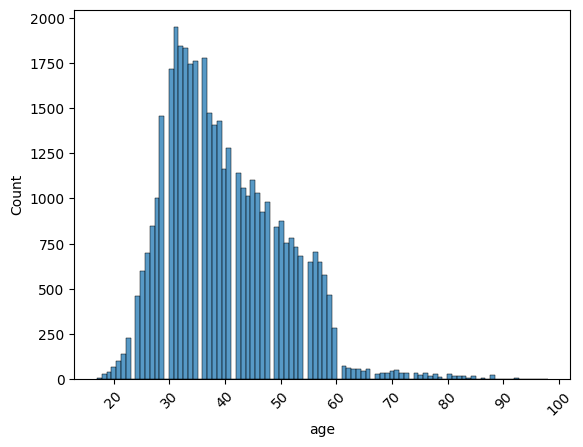

In [56]:
# Hist plot on age
sns.histplot(data=df,x='age')
plt.xticks(rotation=45);

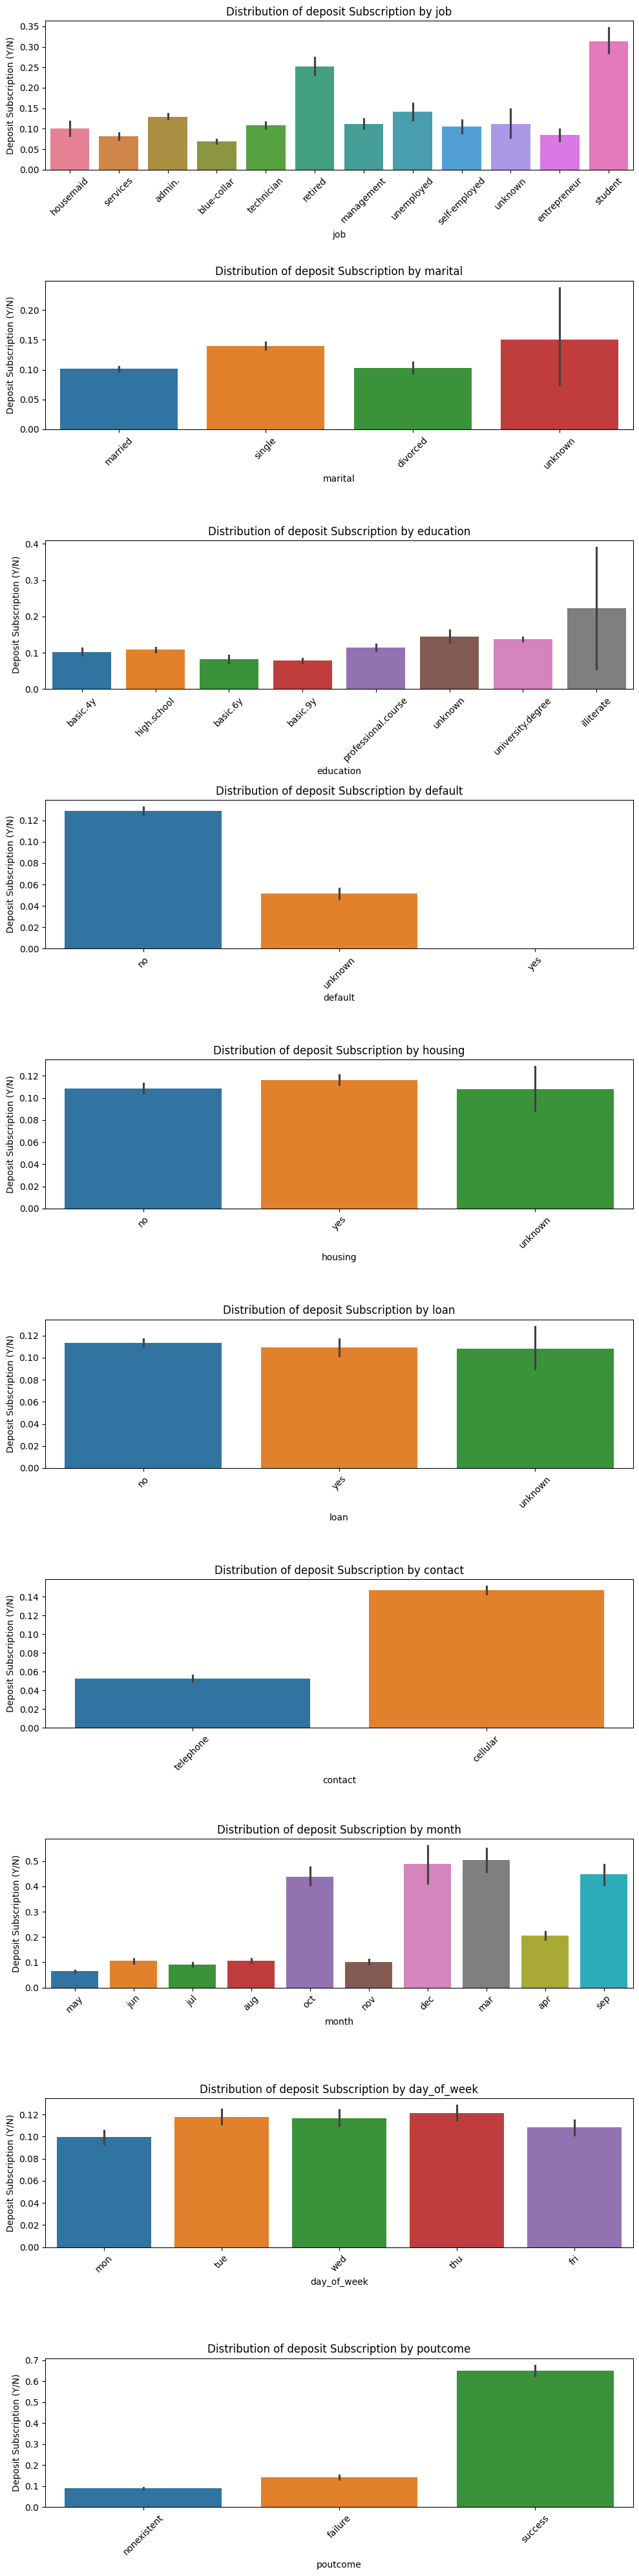

In [57]:
# Bar Plot - Bivariate Analsis for Categorical Columns
obj_columns = df.select_dtypes(include=['object']).columns.tolist()
plt.figure(figsize=(10, len(obj_columns) * 4))

for i, col in enumerate(obj_columns, 1):
    plt.subplot(len(obj_columns), 1, i)
    sns.barplot(data= df, x=col, y='y',hue=col)
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Deposit Subscription (Y/N)")
    plt.title(f"Distribution of deposit Subscription by {col}")
plt.tight_layout()
plt.show();

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**After Examining the dataset the below changes/updates where done**

**Columns to be dropped**
1. Housing - as the housing values has equal distribution for yes/no/unkown for people who has accepted to open the term deposit
2. euribor3m - Is between institutions and not related to the Customer
3. default - Belonged to the 99.9% of the category value, In this case "No", seems to be a data input issue.
4. loan - No Impact on the target.
5. day_of_week - Not much impact
6. cons.price.idx - Dependant value was equally split which will not be useful in prediction.
7. pdays - No Meaningful data.
8. nr.employed - Assumption is it for the institution.

**Columns that we considered from Imputation**

1. age- people over 65 can be removed - This to Remove Outliers.
2. education - basic education combined as a single values (basic.4y,6y,9y)

In [58]:
# Columns to drop - Not Much impact on the Target column.
columns_drop ={'housing' ,'euribor3m','default','loan','day_of_week','pdays','nr.employed','cons.price.idx'}
bank_df = df.copy()
bank_df.drop(columns=columns_drop,inplace=True)

In [59]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            41176 non-null  int64  
 1   job            41176 non-null  object 
 2   marital        41176 non-null  object 
 3   education      41176 non-null  object 
 4   contact        41176 non-null  object 
 5   month          41176 non-null  object 
 6   duration       41176 non-null  int64  
 7   campaign       41176 non-null  int64  
 8   previous       41176 non-null  int64  
 9   poutcome       41176 non-null  object 
 10  emp.var.rate   41176 non-null  float64
 11  cons.conf.idx  41176 non-null  float64
 12  y              41176 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 4.4+ MB


In [60]:
# Removed outliers for age
bank_df= bank_df[bank_df.age<=65]

In [61]:
# Validate for filtered data.
bank_df[bank_df.age>65]

,age,job,marital,education,contact,month,duration,campaign,previous,poutcome,emp.var.rate,cons.conf.idx,y


In [62]:
#  basic education combined as a single values (basic.4y,6y,9y)
bank_df.loc[:,'education'] = np.where((bank_df['education']=='basic.4y')|(bank_df['education']=='basic.6y')|(bank_df['education']=='basic.9y'),'basic',bank_df['education'])

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [63]:
X=bank_df.drop(columns='y')
y=bank_df['y']

In [64]:
# Encoding of Categorical and Standardization of Numerical Attributes

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_cols),
    ("num", StandardScaler(), numeric_cols)
])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [66]:
results_df = pd.DataFrame(columns=['Model','Time Taken', 'Train Accuracy', 'Train Precision','Train Recall','Train F1', 'Test Accuracy', 'Test Precision','Test Recall','Test F1'])

In [67]:
def model_score(model,model_name,X_train,X_test, y_train, y_test):

    starttime = time.time()
    #Fit Model
    model.fit(X_train, y_train)
    #Predict for Training and Test Dataset
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    endtime =time.time()
    #Time Taken
    time_tkn =  endtime - starttime
    #accuracy_score
    acc_train=accuracy_score(y_train,y_pred_train)
    acc_test=accuracy_score(y_test,y_pred_test)
    #Precision_score
    precision_train=precision_score(y_train,y_pred_train,zero_division=0)
    precision_test=precision_score(y_test,y_pred_test,zero_division=0)
    #recall_score
    recall_train=recall_score(y_train,y_pred_train,zero_division=0)
    recall_test=recall_score(y_test,y_pred_test,zero_division=0)
    #F1 score
    f1_train=f1_score(y_train,y_pred_train,zero_division=0)
    f1_test=f1_score(y_test,y_pred_test,zero_division=0)
    results_df.loc[len(results_df)] = [model_name, time_tkn, acc_train, precision_train,recall_train,f1_train,acc_test, precision_test,recall_test,f1_test] ;

In [68]:

baseline = DummyClassifier(strategy='most_frequent',random_state=42)
model_score(baseline,'Baseline',X_train,X_test,y_train,y_test)
results_df

,Model,Time Taken,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Baseline,0.00581,0.892776,0.0,0.0,0.0,0.892751,0.0,0.0,0.0


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [69]:

logpipe= Pipeline([('preprocessor',preprocessor),
                   ('logreg',LogisticRegression())])

model_score(logpipe,'Logistic Regression',X_train,X_test,y_train,y_test)

results_df[results_df['Model']=='Logistic Regression']

,Model,Time Taken,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
1,Logistic Regression,0.463194,0.912809,0.657614,0.389767,0.489442,0.914201,0.669261,0.395402,0.49711


### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [70]:

svcpipe = Pipeline([('preprocessor',preprocessor),
                    ('svc',SVC())])
model_score(svcpipe,'SVC',X_train,X_test,y_train,y_test)
results_df[results_df['Model']=='SVC']

,Model,Time Taken,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
2,SVC,46.00101,0.924367,0.738928,0.455591,0.563656,0.917899,0.692453,0.421839,0.524286


In [71]:

dectreepipe = Pipeline([('preprocessor',make_column_transformer((OneHotEncoder(drop='first'),cat_cols),
                                                                remainder='passthrough')),
                    ('dectree',DecisionTreeClassifier())])
model_score(dectreepipe,'Decision Tree',X_train,X_test,y_train,y_test)
results_df[results_df['Model']=='Decision Tree']

,Model,Time Taken,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
3,Decision Tree,1.40949,0.999908,1.0,0.999138,0.999569,0.892875,0.500578,0.497701,0.499135


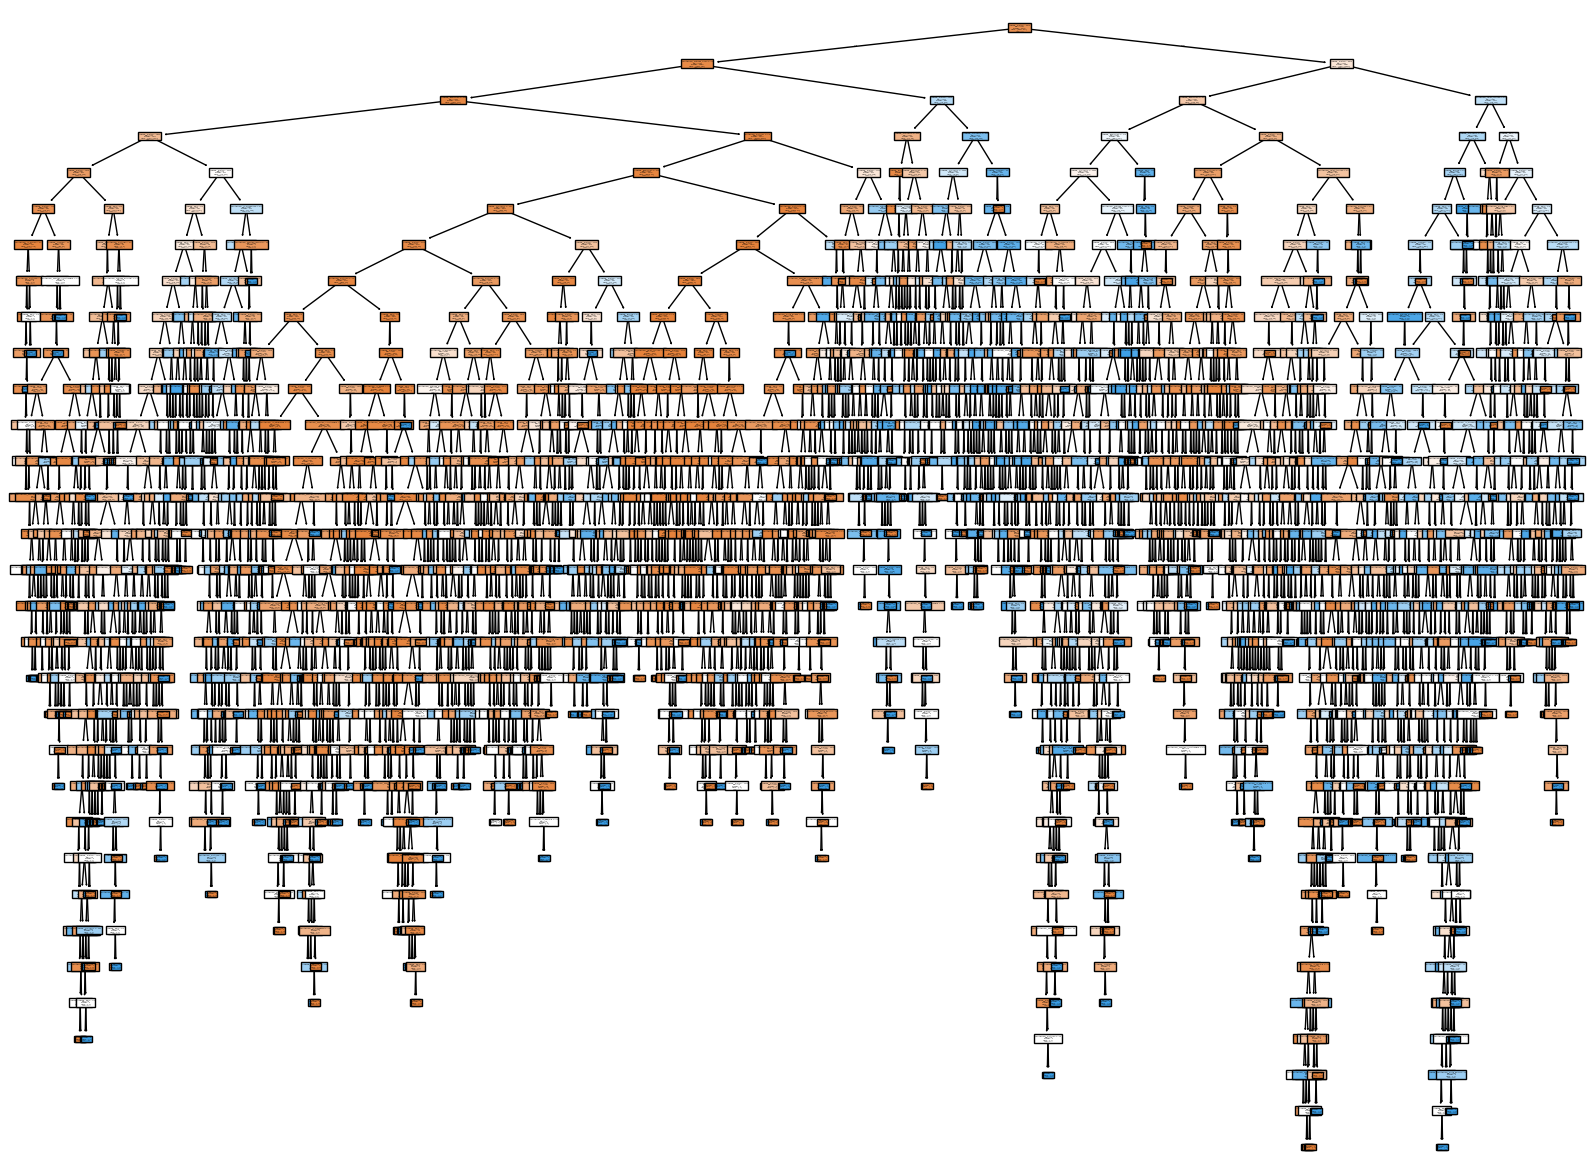

In [72]:
preprocessor = dectreepipe.named_steps['preprocessor']

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Then plot tree using these feature names
plt.figure(figsize=(20, 15))
plot_tree(dectreepipe.named_steps['dectree'],
          feature_names=feature_names,
          class_names=["no", "yes"],
          filled=True) ;

In [73]:

knnpipe = Pipeline([('preprocessor',preprocessor),
                ('knn',KNeighborsClassifier())])
model_score(knnpipe,'KNN',X_train,X_test,y_train,y_test)
results_df[results_df['Model']=='KNN']


,Model,Time Taken,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
4,KNN,92.935108,0.924213,0.735675,0.457603,0.564239,0.893984,0.509843,0.297701,0.375907


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [74]:
from sklearn.metrics import make_scorer

logpipe= Pipeline([('preprocessor',preprocessor),
                   ('logreg',LogisticRegression())])


params = {'logreg__C': [0.01, 0.1, 1, 10],
          'logreg__penalty': ['l2','l1'] ,
          'logreg__solver': ['liblinear']
          }
scoring = {
    'f1': make_scorer(f1_score,zero_division=0,pos_label=1),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}


grid = GridSearchCV(logpipe, param_grid=params, scoring=scoring, refit='roc_auc',cv=5, n_jobs=-1)

model_score(grid,'Grid Logistic Regression',X_train,X_test,y_train,y_test)
results_df[results_df['Model']=='Grid Logistic Regression']
print(f'Grid Best Score :{grid.best_score_}')
print(f'Grid Best Params :{grid.best_params_}')

Grid Best Score :0.9332001325170356
Grid Best Params :{'logreg__C': 1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [75]:
params = {'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10],
    'dectree__min_samples_leaf': [1, 2, 4],
    'dectree__criterion': ['gini', 'entropy']
          }
scoring = {
    'f1': make_scorer(f1_score,zero_division=0,pos_label=1),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}


grid = GridSearchCV(dectreepipe, param_grid=params, scoring=scoring, refit='roc_auc',cv=5, n_jobs=-1)
model_score(grid,'Grid DecisionTreeClassifier',X_train,X_test,y_train,y_test)
results_df[results_df['Model']=='Grid DecisionTreeClassifier']
print(f'Grid Best Score :{grid.best_score_}')
print(f'Grid Best Params :{grid.best_params_}')

Grid Best Score :0.9330415799176526
Grid Best Params :{'dectree__criterion': 'entropy', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 4, 'dectree__min_samples_split': 10}


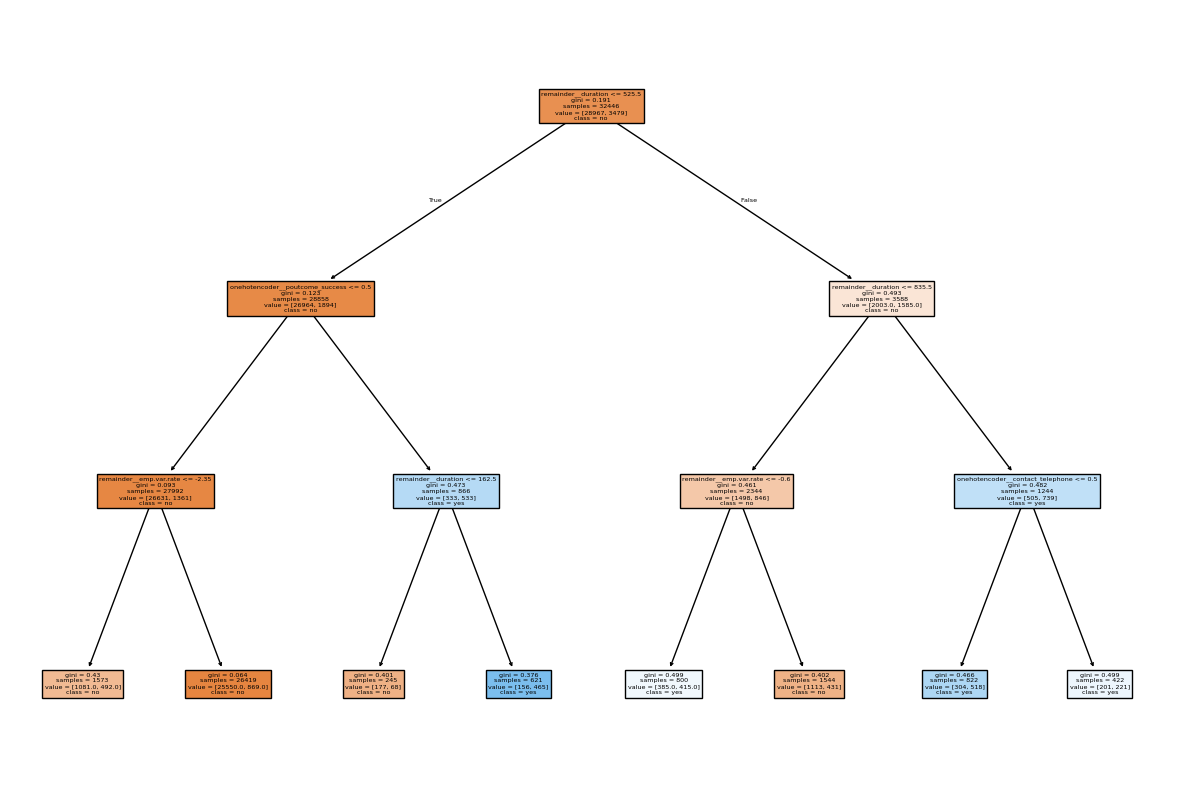

In [76]:
dectreepipe = Pipeline([('preprocessor',preprocessor),
                    ('dectree',DecisionTreeClassifier(criterion='gini',max_depth=3,min_samples_leaf=1,min_samples_split=2))]).fit(X_train,y_train)
preprocessor = dectreepipe.named_steps['preprocessor']

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Then plot tree using these feature names
plt.figure(figsize=(15, 10))
plot_tree(dectreepipe.named_steps['dectree'],
          feature_names=feature_names,
          class_names=["no", "yes"],
          filled=True) ;

In [77]:
params = {'knn__n_neighbors': [3, 5, 7, 9],
    'knn__n_jobs': [-1]
          }
scoring = {
    'f1': make_scorer(f1_score,zero_division=0,pos_label=1),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

grid = GridSearchCV(knnpipe, param_grid=params, scoring=scoring, refit='roc_auc',cv=5, n_jobs=-1)
model_score(grid,'Grid KNN',X_train,X_test,y_train,y_test)
results_df[results_df['Model']=='Grid KNN']
print(f'Grid Best Score :{grid.best_score_}')
print(f'Grid Best Params :{grid.best_params_}')

Grid Best Score :0.8615945382836989
Grid Best Params :{'knn__n_jobs': -1, 'knn__n_neighbors': 9}


In [78]:
params = {'svc__C': [0.01, 0.1, 1,10],
          'svc__degree': [1,2]
          }

svcpipe = Pipeline([('preprocessor',preprocessor),
                    ('svc',SVC())])
starttime = time.time()

grid = GridSearchCV(svcpipe, param_grid=params, scoring=recall_score,cv=5, n_jobs=-1)
model_score(grid,'Grid SVC',X_train,X_test,y_train,y_test);
results_df[results_df['Model']=='Grid SVC']
print(f'Grid Best Score :{grid.best_score_}')
print(f'Grid Best Params :{grid.best_params_}')

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Grid Best Score :nan
Grid Best Params :{'svc__C': 0.01, 'svc__degree': 1}


In [79]:
results_df.sort_values(['Test Precision','Test Recall'],ascending=False)
#

,Model,Time Taken,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
2,SVC,46.001010,0.924367,0.738928,0.455591,0.563656,0.917899,0.692453,0.421839,0.524286
1,Logistic Regression,0.463194,0.912809,0.657614,0.389767,0.489442,0.914201,0.669261,0.395402,0.497110
5,Grid Logistic Regression,29.571240,0.912840,0.657933,0.389767,0.489531,0.913955,0.667969,0.393103,0.494935
6,Grid DecisionTreeClassifier,113.825751,0.919651,0.647297,0.550733,0.595123,0.919009,0.642953,0.550575,0.593189
8,Grid SVC,673.343863,0.897491,0.593407,0.139695,0.226152,0.897066,0.592593,0.128736,0.211520
4,KNN,92.935108,0.924213,0.735675,0.457603,0.564239,0.893984,0.509843,0.297701,0.375907
3,Decision Tree,1.409490,0.999908,1.000000,0.999138,0.999569,0.892875,0.500578,0.497701,0.499135
7,Grid KNN,861.061518,0.913148,0.689181,0.346076,0.460773,0.892382,0.496520,0.245977,0.328978
0,Baseline,0.005810,0.892776,0.000000,0.000000,0.000000,0.892751,0.000000,0.000000,0.000000


**Model Evaluation Report**

**Overview**

We executed various classification machine learning models on the Portugal – Bank Deposit Subscription Dataset to identify a model with strong performance. We compared metrics including accuracy, precision, recall, F1-score, along with the runtime of each model.

**Key Observations**

* The dataset is imbalanced; therefore, accuracy alone is not a reliable performance measure.

* SVC and SVC with hyperparameter tuning showed significant differences in runtime.

* The highest test accuracy was observed with the Decision Tree Classifier when combined with GridSearchCV.

* The Decision Tree Classifier exhibited a large gap between training and test performance, indicating overfitting.

* Logistic Regression produced balanced precision and recall scores.

* For the SVC models, precision was consistently higher than recall.

* The Decision Tree Classifier without parameter tuning showed severe overfitting.

* KNN models demonstrated moderate overfitting.

* SVC with GridSearchCV showed the least overfitting but yielded poor recall values.

**Inference**

Based on the dataset and the applied transformations, SVC performed better overall compared to other models. However, its recall performance needs improvement. Despite this limitation, SVC can be considered a suitable model for predicting deposit subscription outcomes in this dataset.

##### Questions